## Using GSKY to replace datacube

### This notebook will demonstrate the use of GSKY to retrieve and display landsat data.

#### Example 5

This is exacly like  example 3 with the exception that you can specify an area larger than one tile. For this, identify the top left corner tile (e.g. -12_-35) and the bottom right corner tile (e.g. -11_-36). A BBox covering a square (or rectangle) with these tiles as reference points will be generated.

###### Specifics

- Converting a DEA notebook example to use GSKY instaed of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.
    -- where an area around a single point is calculated ("LoadingCloudfreeSentinel2andLandsat.ipynb").

- This example can only use one sensor ("ls8") instead of three sensors as DEA has used.

- The required area is specified a tile from a list that shows the bounding boxes. 

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 22 October, 2019

### How to use

Use this notebook to display a GSKY layer corresponding to a time slice and bounding box (BBox) larger than one tile. For this, identify the top left corner tile (e.g. -12_-35) and the bottom right corner tile (e.g. -11_-36). A BBox covering a square (or rectangle) with these tiles as reference points will be generated.

- Specify the name of layer in cell 2
    - layer = "landsat8_nbar_16day"
    - If necessary, uncomment its code block to see all available layers.

- Identify the available time positions (dates of data acquisitions) in cell 3
    - Give m,n values to display the range of dates (from 0 to n_times-1)
    - Give t=i to say which date to use, where i = 0 to n_times-1.

- Identify the tile ID in cell 4

- Specify the tile ID in cell 5
    - If you know another BBox with data (Tip: use TerriaMap to find) then type it in as,
        - bbox = (130.00, -27.00, 131.00, -29.00)

- Execute all cells from top to bottom.

In [11]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 18/10/2019; Last Modified: 18/10/2019  #
##########################################################

from owslib.wcs import WebCoverageService
from random import randrange
import os
import xarray as xr
%matplotlib inline
import numpy as np

#### Specify the GSKY capabilities end URL is below. It must be one that you can access. 

Normally there are several GSKY layers in the dataset. You must select one layer to view the data. By uncommenting its code you can display all available layers.

In [12]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
layer = "landsat8_nbar_16day"
wcs = WebCoverageService(gsky_url, version='1.0.0')

# Uncomment below to see all layers.
#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

#### A time slice must be specified to show the layer. 

To help identify a time slice, specify the start and end values as m,n below, which will show the time slices in that range. Then specify the time slice as 't = i', where i = 0 to n_times-1

In [13]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times-1
# print ("Total of", n_times,'timepositions:\n\n', time[m:n])

# The time slice whose data is to be displayed is specified below. 
t = n-3

#### The Australian continent is divided into approximately 1x1 degree tiles, from -22 to +27 longitude degrees from a line through the centre of Australia.

The ID and BBox for each tile will be generated in the next box. Choose a tile by its ID to display the layer.

In [14]:
tiles_list = {}
with open("tiles_bboxes.txt") as f:
    for line in f:
        (key, val) = line.split()
        tiles_list[str(key)] = val

# Uncomment below to see all tiles and ther BBoxes
#tiles_list

#### You must select a tile to get its BBox, after verifying that the tile has some data for the chosen layer and time.

You can give a single tile as **" tiles = \['-11_-38'\] "** or two tiles as in **" tiles = \['-11_-38','-11_-40'\]"**, where the first tile is the top left corner and the second tile is the bottom right corner of the area to be plotted. The BBox will be generated from these and scaled to fit the plot. The final output could be slightly larger than the selected BBox.

In [15]:
tiles = ['-10_-30','-8_-35']
bbox = [tiles_list[tiles[0]],tiles_list[tiles[1]]]
x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[1][14:20])
Y = float(bbox[1][21:27])
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 340)))
bbox = (x,y,X,Y)
bbox

(121.76, -26.41, 130.29, -31.93)

#### A call is made to the GSKY server to get the data.

In [16]:
# Construct the URL for a WCS call and send it to the GSKY server.
# Style can be False Color (fc) or True Color (tc)
# This NB uses only NetCDF and EPSG:4326. Hence, do not change these.
# If any error, the displayed URL can be opened in a browser to see the actual error message.
output = wcs.getCoverage(identifier=layer, Styles='fc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
print(output.geturl())

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=121.76%2C-26.41%2C130.29%2C-31.93&time=2019-11-02T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=fc


#### The returned data in NetCDF format is written to a file.

In [17]:
# Get the output data from GSKY and write it in a *.nc file
# A random number is inserted in the filename to prevent the browser caching the file content.
rand = str(randrange(1000))
ncfile = './output/gsky_wcs_' + rand + '.nc'
with open(ncfile, 'wb') as f:
    f.write(output.read())

#### The saved NetCDF file is read again and plotted as a map.

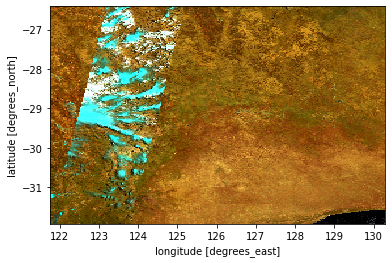

In [18]:
# Read the NetCDF file and convert it into an xarray dataset
landsat_ds = xr.open_dataset(ncfile)

# Delete the created NetCDF file
try:
    os.remove(ncfile)
except OSError:
    pass

# Plot the three bands in the dataset.
landsat_ds[['Band1', 'Band2', 'Band3']].to_array().plot.imshow(robust=True)

# Uncomment below to see the raw data
#landsat_ds

In [19]:
# View the raw data and band names
#landsat_ds

### Identify valid pixels

Here we choose a single band from the Landsat data, and test whether each pixel contains valid values using the function np.isfinite. This will give us a dataset that contains False for any invalid pixel, and True for any valid observation.

We will later use this to normalise our counts of snow to account for missing data.

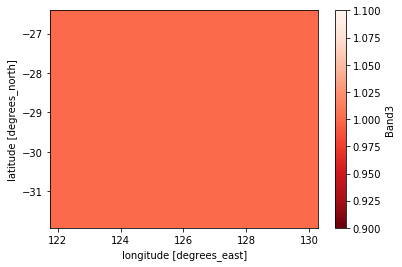

In [20]:
# Identify which pixels contain valid data in the Landsat dataset
valid_ds = np.isfinite(landsat_ds.Band3)

# Plot one sample timestep from the `valid_ds` dataset. Red below represents
# invalid pixels, due to either issues with terrain shadow on steep mountains,
# cloud cover, snow accidently mapped as cloud, or edges of Landsat overpasses
valid_ds.isel().plot(cmap='Reds_r')

# End of cells